# Predicting the Perception of Above-the-Fold Time in Web Browsing

## PCT implementation

#### Jahromi, H.Z.; Delaney, D.; Hines, A. A Sign of Things to Come: Predicting the Perception of Above-the-Fold Time in Web Browsing. Future Internet 2021, 13, 50. https://doi.org/10.3390/fi13020050

In [1]:
import cv2
import json
import os
import numpy as np
from IPython.display import Image
import matplotlib.image as mpimg
import pandas as pd
from skimage import measure
import warnings
warnings.filterwarnings('ignore')
import matplotlib.ticker as mt
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import MultipleLocator
import matplotlib.ticker as mticker
import datetime as dt
import matplotlib.dates as pdt
import time
import matplotlib
import matplotlib.pylab as plt
import datetime
from pylab import *
from datetime import  time
import glob
import shutil
import pylab as px
from sklearn.preprocessing import minmax_scale

In this section, we navigate through the dataset and list all the videos of web browsing. You can record the video with your own tool. However, please make sure that only the browser frame is recorded, and the browsing starts with a white background. You can upload as many videos as you want and compute PCT, ATF and SI for all web browsing videos. 

In [2]:
data_dir='Videos'
frame_dir='Frames/'
file_names=[]
count=0
for root, dirs, files in os.walk(data_dir):  
    for filename in files:
        if filename.endswith('.avi'):
            file_names.append(filename)
            
col_names =  ['Website','PCT','ATF','SI-ATF','SI-PCT']
metrics_df = pd.DataFrame(columns = col_names)
print(file_names)

['3_theaa_ie.avi', '3_independent_ie.avi', '3_harveynorman_ie.avi', '3_gumtree_ie.avi', '3_autoexpress_co.uk.avi', '3_next_ie.avi', '3_aldi_ie.avi']


The following cells define the common functions that required to implement the PCT algortithem

In [3]:
def deleteframes(mydir):
    filelist = [ f for f in os.listdir(mydir) if f.endswith(".png") ]
    for f in filelist:
        os.remove(os.path.join(mydir, f))

In [4]:
def extractframes(file_name,path,_h,_w):   
    deleteframes(path)
    dim = (_w, _h)
    vidcap = cv2.VideoCapture(file_name)
    fps = vidcap.get(cv2.CAP_PROP_FPS)
    print("Frames per second using video.get(cv2.CAP_PROP_FPS) : ",fps)    
    print('Filename:',file_name)
    success,image = vidcap.read()
    count = 0
    while success:
      if (_w!=0) or (_h!=0):
        image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
      cv2.imwrite(path+"frame%d.png" % count, image)     # save frame as JPEG file
      success,image = vidcap.read()
      count += 1
    return count

In [5]:
def get_frames_array(frames_folder):
    file_names=[]
    count=0
    for root, dirs, files in os.walk(frames_folder):  
        for filename in files:
            file_names.append(frames_folder+"/"+filename)
    return file_names

The following cell is the main PCT computation function. For a detailed explanation, please read the PCT paper: https://doi.org/10.3390/fi13020050

In [6]:
def compute_pct(frames_folder):   
    binaryAccumulatorMatrix=[[]]
    ssimMatrix=[]
    binaryMatrix=[]   
    cumulativeSum=[]
    normalizedCSum=[]
    binaryMatrix=np.zeros((133, 200)) 
    ssim_matrx=np.zeros((133, 200)) 
    
    for i in range (0,len(frames)-1):
    
        #read two consecutive frames
        img_a = cv2.imread('Frames/'+"frame%d.png" % (i))
        img_b = cv2.imread('Frames/'+"frame%d.png" % (i+1))
        
        #convert to grayscale
        grayA = cv2.cvtColor(img_a, cv2.COLOR_BGR2GRAY)
        grayB = cv2.cvtColor(img_b, cv2.COLOR_BGR2GRAY)
        
        # this is used to get rid of light backgroud colors and convert the image to black and white
        (thresh, grayA) = cv2.threshold(grayA, 127, 255, cv2.THRESH_BINARY)
        (thresh, grayB) = cv2.threshold(grayB, 127, 255, cv2.THRESH_BINARY)
        
        #compute SSIM
        (score, diff) = measure.compare_ssim(grayA, grayB, full=True)
        
        ##Reverse the SSIM result 
        diff_2=diff-1.0
        ssim_matrx=diff_2*-1
        
        #apply binary mask
        binaryMatrix=ssim_matrx>0
        binaryMatrix=binaryMatrix.astype(bool)
        
        if (i==0):
            binaryAccumulatorMatrix[0]=np.zeros((133, 200))
            binaryAccumulatorMatrix[0]=binaryAccumulatorMatrix[0].astype(bool)
            binaryAccumulatorMatrix.append(binaryMatrix)
        else:
            binaryAccumulatorMatrix.append(np.bitwise_or(binaryAccumulatorMatrix[i],binaryMatrix))
        cumulativeSum.append(count_nonzero(binaryAccumulatorMatrix[i]))
    normalizedCSum=minmax_scale(cumulativeSum)
    pct=next((x for x in normalizedCSum if x >0.99))
    pct_frame=np.where(normalizedCSum == pct)  
    pct_frame=pct_frame[0][0]
    pct=pct_frame*100
    return pct_frame,pct

In the following cells, the functions related to the state of the art SpeedIndex are implemented. Some of those functions are used from https://github.com/WPO-Foundation/visualmetrics

In [7]:
def get_ATF(progress):
    import re
    for idx,p in enumerate(progress):
            if (p['progress']==100):
                return (p['time'])

def calculate_image_histogram(file):
    try:
        from PIL import Image
        im = Image.open(file)
        width, height = im.size
        colors = im.getcolors(width * height)
        histogram = {'r': [0 for i in range(256)],
                     'g': [0 for i in range(256)],
                     'b': [0 for i in range(256)]}
        for entry in colors:
            try:
                count = entry[0]
                pixel = entry[1]
                # Don't include White pixels (with a tiny bit of slop for
                # compression artifacts)
                if pixel[0] < 250 or pixel[1] < 250 or pixel[2] < 250:
                    histogram['r'][pixel[0]] += count
                    histogram['g'][pixel[1]] += count
                    histogram['b'][pixel[2]] += count
            except Exception:
                pass
        colors = None
    except Exception as e:
        print(e)
        histogram = None
    return histogram

def calculate_histograms(directory, histograms_file,f_frame,l_frame):
    histograms = []
    for i in range (f_frame,l_frame):
        frame=(directory+"/"+"frame%d.png" % (i))
        try:
            frame_time = ((i-f_frame)/10)*1000
            #print(i,frame_time)
            histogram = calculate_image_histogram(frame)
            if histogram is not None:
                histograms.append(
                    {'time': frame_time,
                     'file': os.path.basename(frame),
                     'histogram': histogram})
        except:
            print(frame)

    if os.path.isfile(histograms_file):
        os.remove(histograms_file)
    with open(histograms_file, 'w') as f:
        json.dump(histograms, f)
    f.close()


def load_histograms(histograms_file):
    histograms = None
    with open(histograms_file) as f: 
        original = json.load(f)
    f.close()
    return original


def calculate_frame_progress(histogram, start, final):
    total = 0
    matched = 0
    slop = 5  # allow for matching slight color variations
    channels = ['r', 'g', 'b']
    for channel in channels:
        channel_total = 0
        channel_matched = 0
        buckets = 256
        available = [0 for i in range(buckets)]
        for i in range(buckets):
            available[i] = abs(histogram[channel][i] - start[channel][i])
        for i in range(buckets):
            target = abs(final[channel][i] - start[channel][i])
            if (target):
                channel_total += target
                low = max(0, i - slop)
                high = min(buckets, i + slop)
                for j in range(low, high):
                    this_match = min(target, available[j])
                    available[j] -= this_match
                    channel_matched += this_match
                    target -= this_match
        total += channel_total
        matched += channel_matched
    progress = (float(matched) / float(total)) if total else 1
    return math.floor(progress * 100)

def calculate_visual_progress(histograms):
    progress = []
    first = histograms[0]['histogram']
    last = histograms[-1]['histogram']
    for index, histogram in enumerate(histograms):
        p = calculate_frame_progress(histogram['histogram'], first, last)
        file_name, ext = os.path.splitext(histogram['file'])
        progress.append({'time': histogram['time'],
                         'file': file_name,
                         'progress': p})
        #print('{0:d}ms - {1:d}% Complete'.format(histogram['time'], int(p)))
    return progress

            
def calculate_speed_index(progress):
    si = 0
    last_ms = progress[0]['time']
    last_progress = progress[0]['progress']
    for p in progress:
        elapsed = p['time'] - last_ms
        si += elapsed * (1.0 - last_progress)
        last_ms = p['time']
        last_progress = p['progress'] / 100.0
    return int(si)

The following cell computes PCT, SpeedIndex based on PCT, state-of-the-art SpeedIndex and ATF. You can visually see the frame that each algorithem predicts the ATF time.

Frames per second using video.get(cv2.CAP_PROP_FPS) :  10.0
Filename: Videos/3_theaa_ie.avi
Number of Exctacted Frames: 71 

Objective ATF= 3800.0 SpeedIndex_ATF= 1781
PCT= 2400 SpeedIndex_pct 1760
Plotting the Result 


<Figure size 432x288 with 0 Axes>

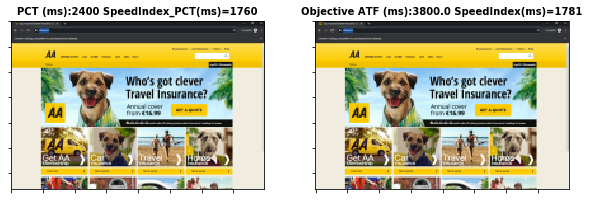

-------------------------------------------------------------------
Frames per second using video.get(cv2.CAP_PROP_FPS) :  10.0
Filename: Videos/3_independent_ie.avi
Number of Exctacted Frames: 225 

Objective ATF= 22300.0 SpeedIndex_ATF= 2647
PCT= 20000 SpeedIndex_pct 1667
Plotting the Result 


<Figure size 432x288 with 0 Axes>

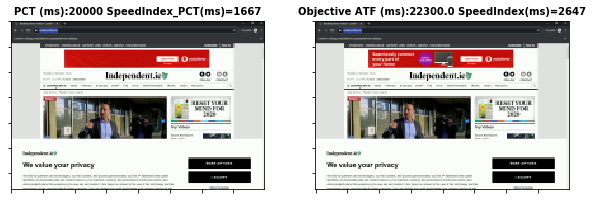

-------------------------------------------------------------------
Frames per second using video.get(cv2.CAP_PROP_FPS) :  10.0
Filename: Videos/3_harveynorman_ie.avi
Number of Exctacted Frames: 870 

Objective ATF= 58200.0 SpeedIndex_ATF= 13575
PCT= 30200 SpeedIndex_pct 10255
Plotting the Result 


<Figure size 432x288 with 0 Axes>

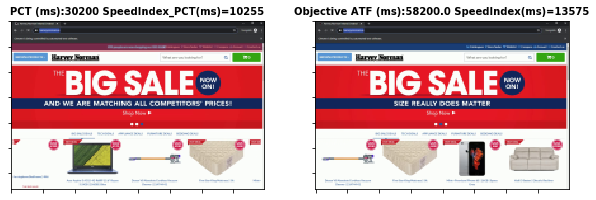

-------------------------------------------------------------------
Frames per second using video.get(cv2.CAP_PROP_FPS) :  10.0
Filename: Videos/3_gumtree_ie.avi
Number of Exctacted Frames: 176 

Objective ATF= 10200.0 SpeedIndex_ATF= 3505
PCT= 9900 SpeedIndex_pct 1987
Plotting the Result 


<Figure size 432x288 with 0 Axes>

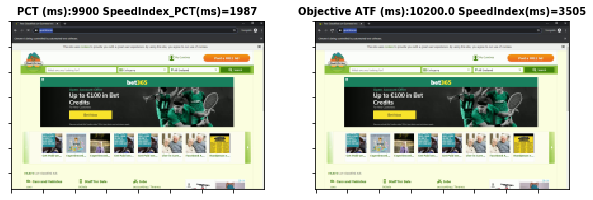

-------------------------------------------------------------------
Frames per second using video.get(cv2.CAP_PROP_FPS) :  10.0
Filename: Videos/3_autoexpress_co.uk.avi
Number of Exctacted Frames: 170 

Objective ATF= 16400.0 SpeedIndex_ATF= 7800
PCT= 8100 SpeedIndex_pct 6213
Plotting the Result 


<Figure size 432x288 with 0 Axes>

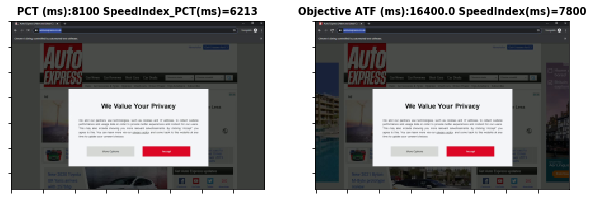

-------------------------------------------------------------------
Frames per second using video.get(cv2.CAP_PROP_FPS) :  10.0
Filename: Videos/3_next_ie.avi
Number of Exctacted Frames: 277 

Objective ATF= 19400.0 SpeedIndex_ATF= 6155
PCT= 11300 SpeedIndex_pct 6077
Plotting the Result 


<Figure size 432x288 with 0 Axes>

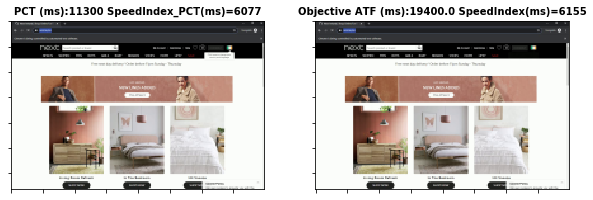

-------------------------------------------------------------------
Frames per second using video.get(cv2.CAP_PROP_FPS) :  10.0
Filename: Videos/3_aldi_ie.avi
Number of Exctacted Frames: 337 

Objective ATF= 32900.0 SpeedIndex_ATF= 7813
PCT= 22800 SpeedIndex_pct 6075
Plotting the Result 


<Figure size 432x288 with 0 Axes>

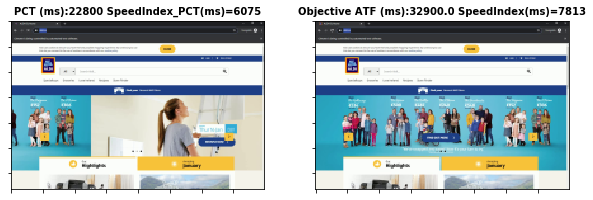

-------------------------------------------------------------------


In [8]:
for file in file_names:
#     try:
    extractframes(data_dir+"/"+file,frame_dir,133,200)
    frames=get_frames_array(frame_dir) 
    print('Number of Exctacted Frames:',len(frames),'\n')
    
    # computing speedindex with objective ATF
    calculate_histograms(frame_dir,"hist.csv",0,len(frames)-1)
    hist=load_histograms("hist.csv")
    vp=calculate_visual_progress(hist)
    objective_ATF=get_ATF(vp)
    si_atf=calculate_speed_index(vp)          
    print('Objective ATF=',objective_ATF,'SpeedIndex_ATF=',si_atf)
    
    
   # computing PCT and speedindex with PCT 
    pct_frame,pct=compute_pct(frame_dir)
    calculate_histograms(frame_dir,"hist.csv",0,pct_frame)
    hist=load_histograms("hist.csv")
    vp=calculate_visual_progress(hist)
    si_pct=calculate_speed_index(vp)          
    print('PCT=',pct,'SpeedIndex_pct',si_pct)    

    #plotting the result
    print("Plotting the Result ")
    %matplotlib inline
    plt.figure()
    rcParams['figure.figsize'] = 10, 4
    rcParams.update({'errorbar.capsize': 2})
    plt.rcParams['axes.labelsize'] = 14
    plt.rcParams['axes.titleweight']= 'bold'
    plt.rcParams['axes.titlesize']= 14
    plt.rcParams['legend.fontsize']= 14
    plt.rcParams['legend.markerscale']=1
    locator = mt.MaxNLocator(nbins=10) 
    rcParams["legend.loc"] ='upper right'
    fig, ax = plt.subplots(1,2)
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.8)

    ax[0].set_title('PCT (ms):'+str(pct)+' SpeedIndex_PCT(ms)='+str(si_pct), fontsize=10)
    ax[1].set_title('Objective ATF (ms):'+str(objective_ATF)+' SpeedIndex(ms)='+str(si_atf), fontsize=10)
    
    img1=mpimg.imread('Frames/frame'+str(pct_frame)+'.png')
    ax[0].imshow(img1)
    img2=mpimg.imread('Frames/frame'+str(int(objective_ATF/100))+'.png')
    ax[1].imshow(img2)    
    
    ax[0].xaxis.set_major_formatter(plt.NullFormatter())
    ax[1].xaxis.set_major_formatter(plt.NullFormatter())
    ax[0].yaxis.set_major_formatter(plt.NullFormatter())
    ax[1].yaxis.set_major_formatter(plt.NullFormatter())
            
    plt.show()    
    print('-------------------------------------------------------------------')
#     except:
#         pass